# Data cleansing and feature engineering

## Getting to know the data

Let's start importing the necessary libraries and loading the dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import EngFormatter

from fraud.config import RAW_DATA_FILE, INTERIM_DATA_FILE
from fraud.utils import best_grid_shape, remove_outliers_quantile

In [2]:
df = pd.read_csv(RAW_DATA_FILE, compression="zip")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
with pd.option_context(
    "display.float_format", "{:.2f}".format, "display.max_columns", None
):
    display(df.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [5]:
df.columns[df.nunique() == 1]

Index([], dtype='object')

In [6]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
df["Class"].value_counts(normalize=True).mul(100).round(2)

Class
0    99.83
1     0.17
Name: proportion, dtype: float64

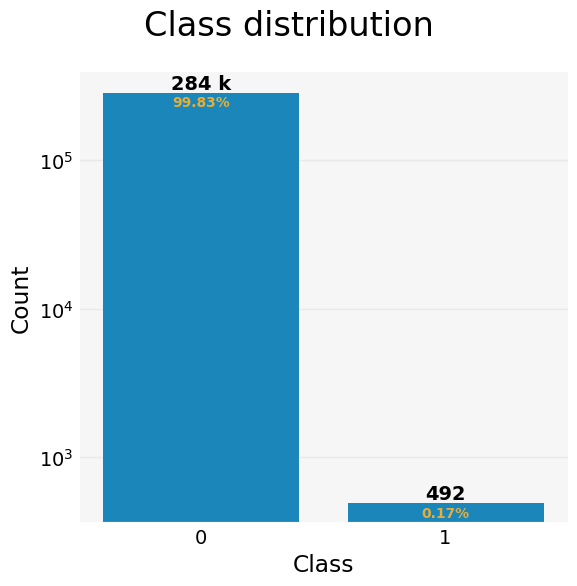

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(data=df, x="Class", ax=ax)

eng_fmt = EngFormatter(places=0)
ax.yaxis.set_major_formatter(eng_fmt)

ax.set_yscale("log")

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=map(eng_fmt.format_eng, df["Class"].value_counts()),
)

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=map(lambda num: f"{num:.2%}", df["Class"].value_counts(normalize=True)),
    padding=-12,
    fontsize=10,
    color="C2",
)


ax.set_xlabel("Class")
ax.set_ylabel("Count")

fig.suptitle("Class distribution")

plt.show()

As shown above, we have 284807 entries and 31 variables. In the [dataset description on Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud), some explanations about the variables are provided:

- Due to confidentiality issues, the identifications of most of the original variables are not provided;
- The variables represented as *V1, V2,... V28* are the result of a transformation by [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), a technique used to condense the information contained in several original variables into a smaller set of statistical variables (components) with minimal loss of information. Later, we will see some consequences of this transformation in our analysis;
- The variables `Time` (time) and `Amount` (transaction value) did not undergo PCA.
    - Time refers to the interval, in seconds, between each transaction and the first one in the dataset.
- The variable `Class` is the target variable:
    - The value `0` signifies a genuine, legitimate transaction
    - The value `1` signifies fraud

There is a class imbalance in the target variable, with only 492 (0.17%) fraud cases. This imbalance can be a problem for the model, as it may not learn enough from the minority class to make accurate predictions. We will address this issue later.

## Checking PCA

We can check that the `V` variables are the result of PCA by analyzing the correlation between them. If the variables are uncorrelated, it means that the PCA transformation was successful.

To understand this, let's briefly recap what PCA does. It is a technique that transforms a set of correlated variables into a set of uncorrelated variables, called principal components. The first principal component explains the largest possible variance in the data, and each subsequent component explains the largest possible variance that is orthogonal to the previous components. This means that the first component explains the most variance, the second component explains the second most variance, and so on. Orthogonality means that the components geometrically form a right angle with each other. Mathematically, this is equivalent to saying that the covariance between the components is zero. This is why we expect the `V` variables to be uncorrelated.

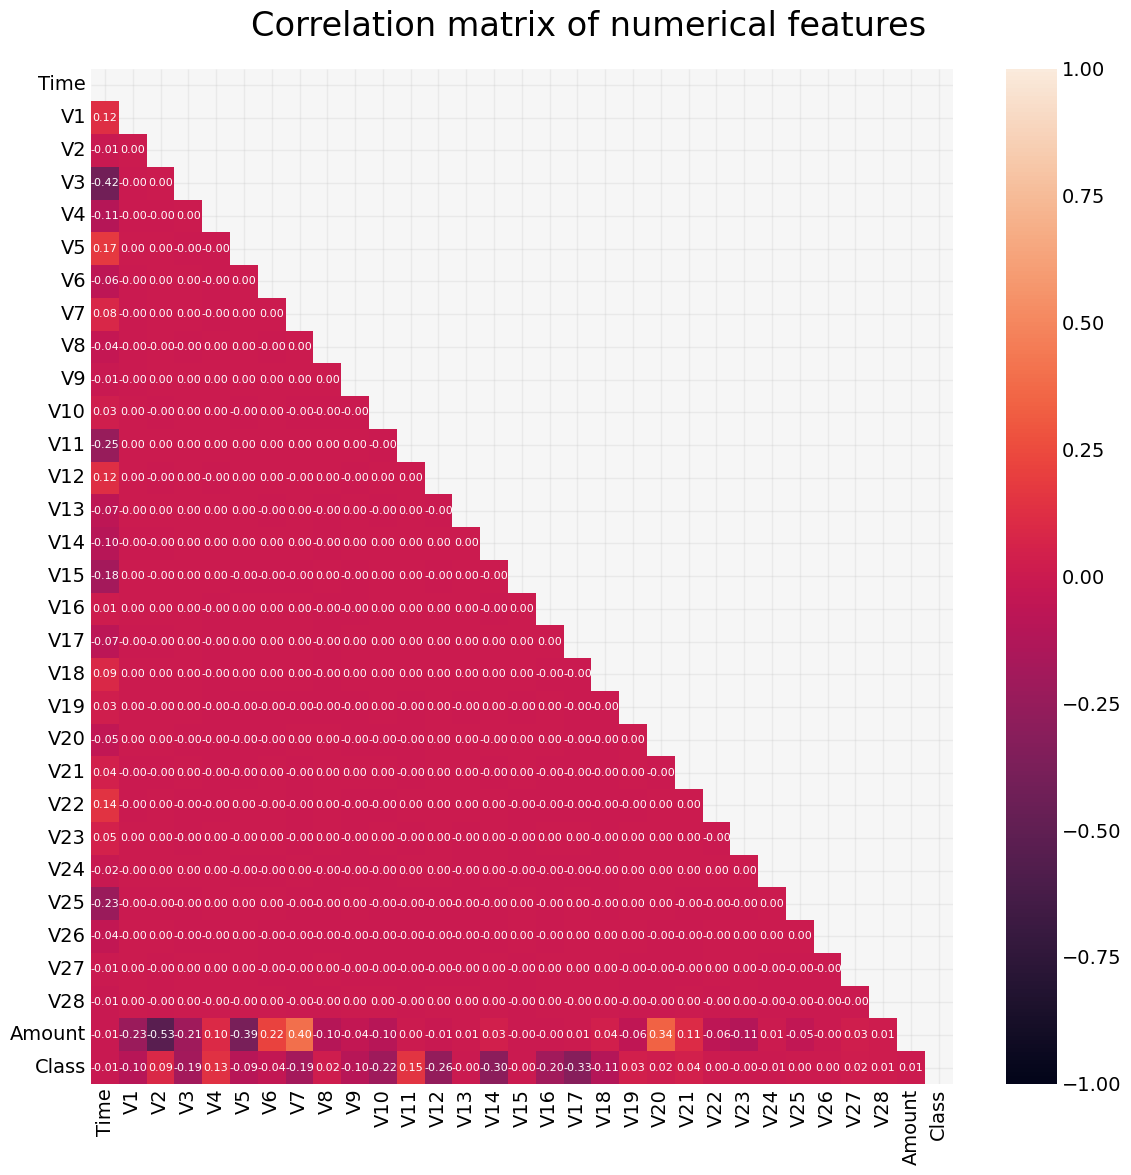

In [9]:
corr = df.select_dtypes("number").corr()

matriz = np.triu(corr)

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(
    corr,
    mask=matriz,
    annot=True,
    fmt=".2f",
    ax=ax,
    annot_kws={"fontsize": 8},
    vmax=1,
    vmin=-1,
)

fig.suptitle("Correlation matrix of numerical features")

plt.show()

As can be seen, the `V` variables are uncorrelated, which confirms that they are the result of PCA.

## Time dependency

We can check if there is a time dependency in the data by analyzing the distribution of the `Time` variable for each class. If there is a time dependency, it means that the time at which the transaction occurred can influence the likelihood of fraud.

First, let's check the time frame of the dataset:

In [10]:
# max time in hours
df["Time"].max() / 3600

np.float64(47.99777777777778)

So, we are dealing with a two-day dataset. Let's analyze the distribution of the `Time` variable for each class.

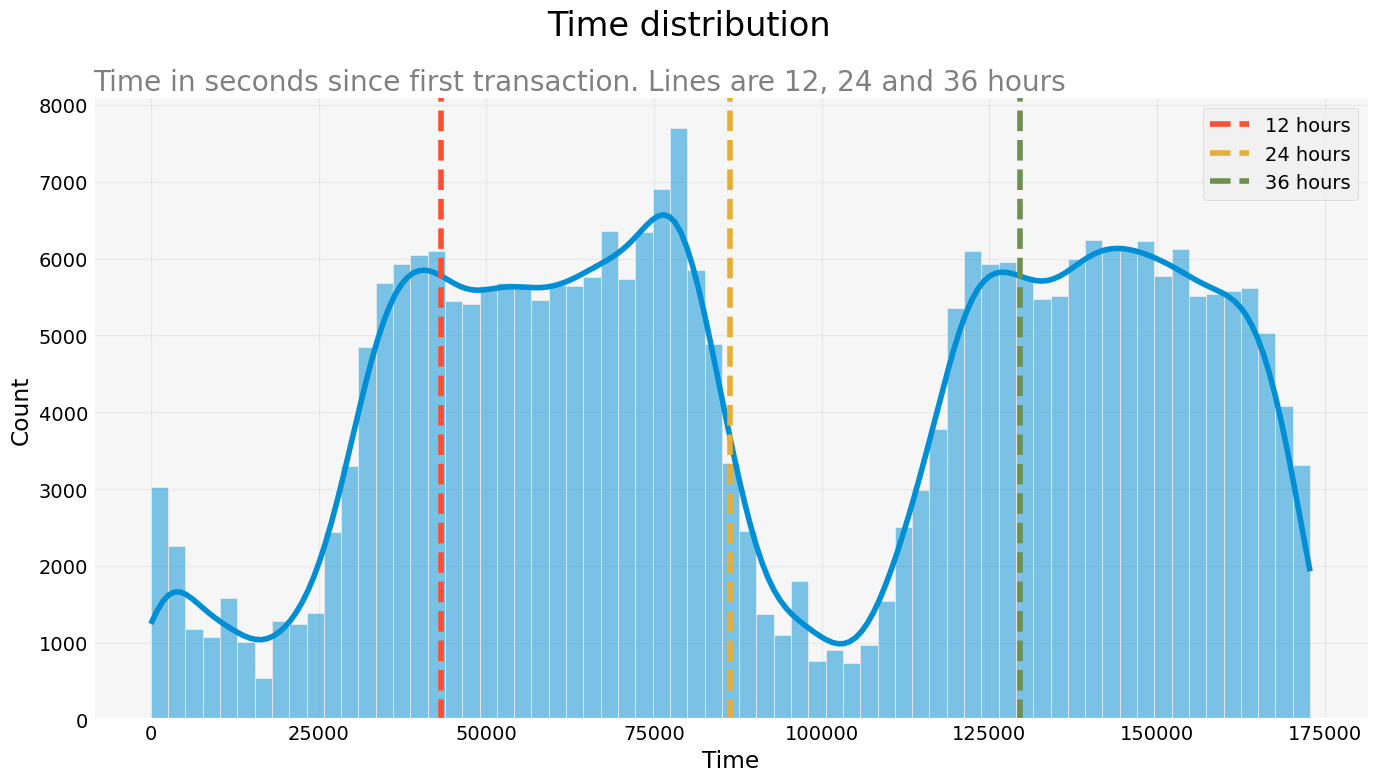

In [11]:
# distribution Time feature
fig, ax = plt.subplots()

sns.histplot(data=df, x="Time", ax=ax, kde=True)

# add vertical lines for 12, 24, 36 hours
for i in range(1, 4):
    ax.axvline(i * 12 * 60 * 60, color=f"C{i}", linestyle="--", label=f"{i * 12} hours")

ax.set_xlabel("Time")
ax.set_ylabel("Count")

ax.legend()

fig.suptitle("Time distribution")
ax.set_title("Time in seconds since first transaction. Lines are 12, 24 and 36 hours")

plt.show()

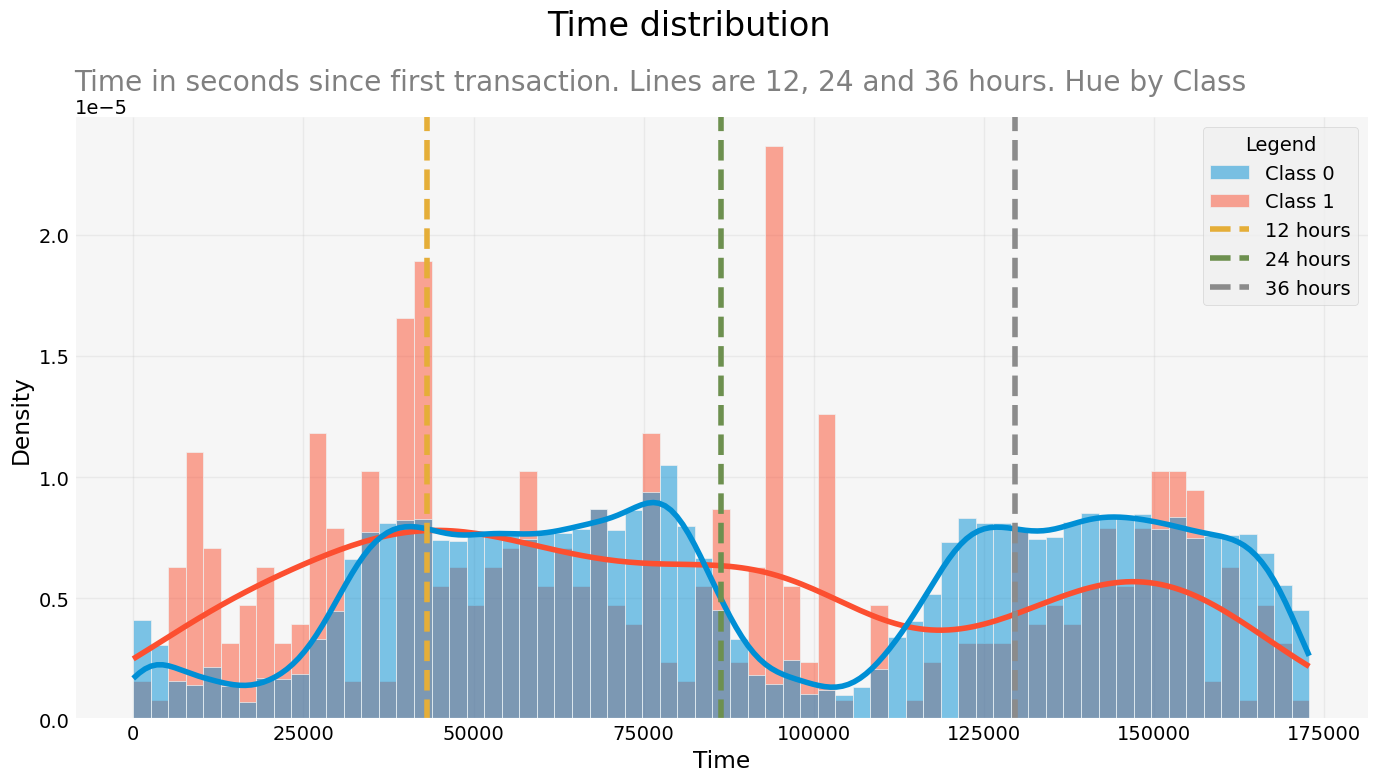

In [12]:
fig, ax = plt.subplots()

h = sns.histplot(
    data=df, x="Time", ax=ax, kde=True, hue="Class", stat="density", common_norm=False
)

# Store the handles/labels from the histplot legend
legend = h.get_legend()
handles, labels = legend.legend_handles, [
    f"Class {text.get_text()}" for text in legend.get_texts()
]

# Add vertical lines for 12, 24, 36 hours and store their handles
vline_handles = []
vline_labels = []

for i in range(1, 4):
    line = ax.axvline(
        i * 12 * 60 * 60, color=f"C{i+1}", linestyle="--", label=f"{i * 12} hours"
    )
    vline_handles.append(line)
    vline_labels.append(f"{i * 12} hours")

# Combine both legend components (histogram + vertical lines)
ax.legend(handles + vline_handles, labels + vline_labels, title="Legend")

ax.set_xlabel("Time")
ax.set_ylabel("Density")

fig.suptitle("Time distribution")
ax.set_title("Time in seconds since first transaction. Lines are 12, 24 and 36 hours. Hue by Class")

plt.show()

While legitimate transactions have an increasing trend during the day, keeping a plateau until evening when they start to decrease, frauds have a smoother distribution, being more evenly distributed throughout the day. Then, they are easier to spot on the plot in the early morning hours, when the number of legitimate transactions is lower.

## Outlier detection

In this section, we will look for outliers in our data. Outliers are data points that are significantly different from the rest of the data. 

In [13]:
columns_to_ignore_outliers = ["Time", "Class"]

search_outliers_columns = [col for col in df.columns if col not in columns_to_ignore_outliers]

search_outliers_columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

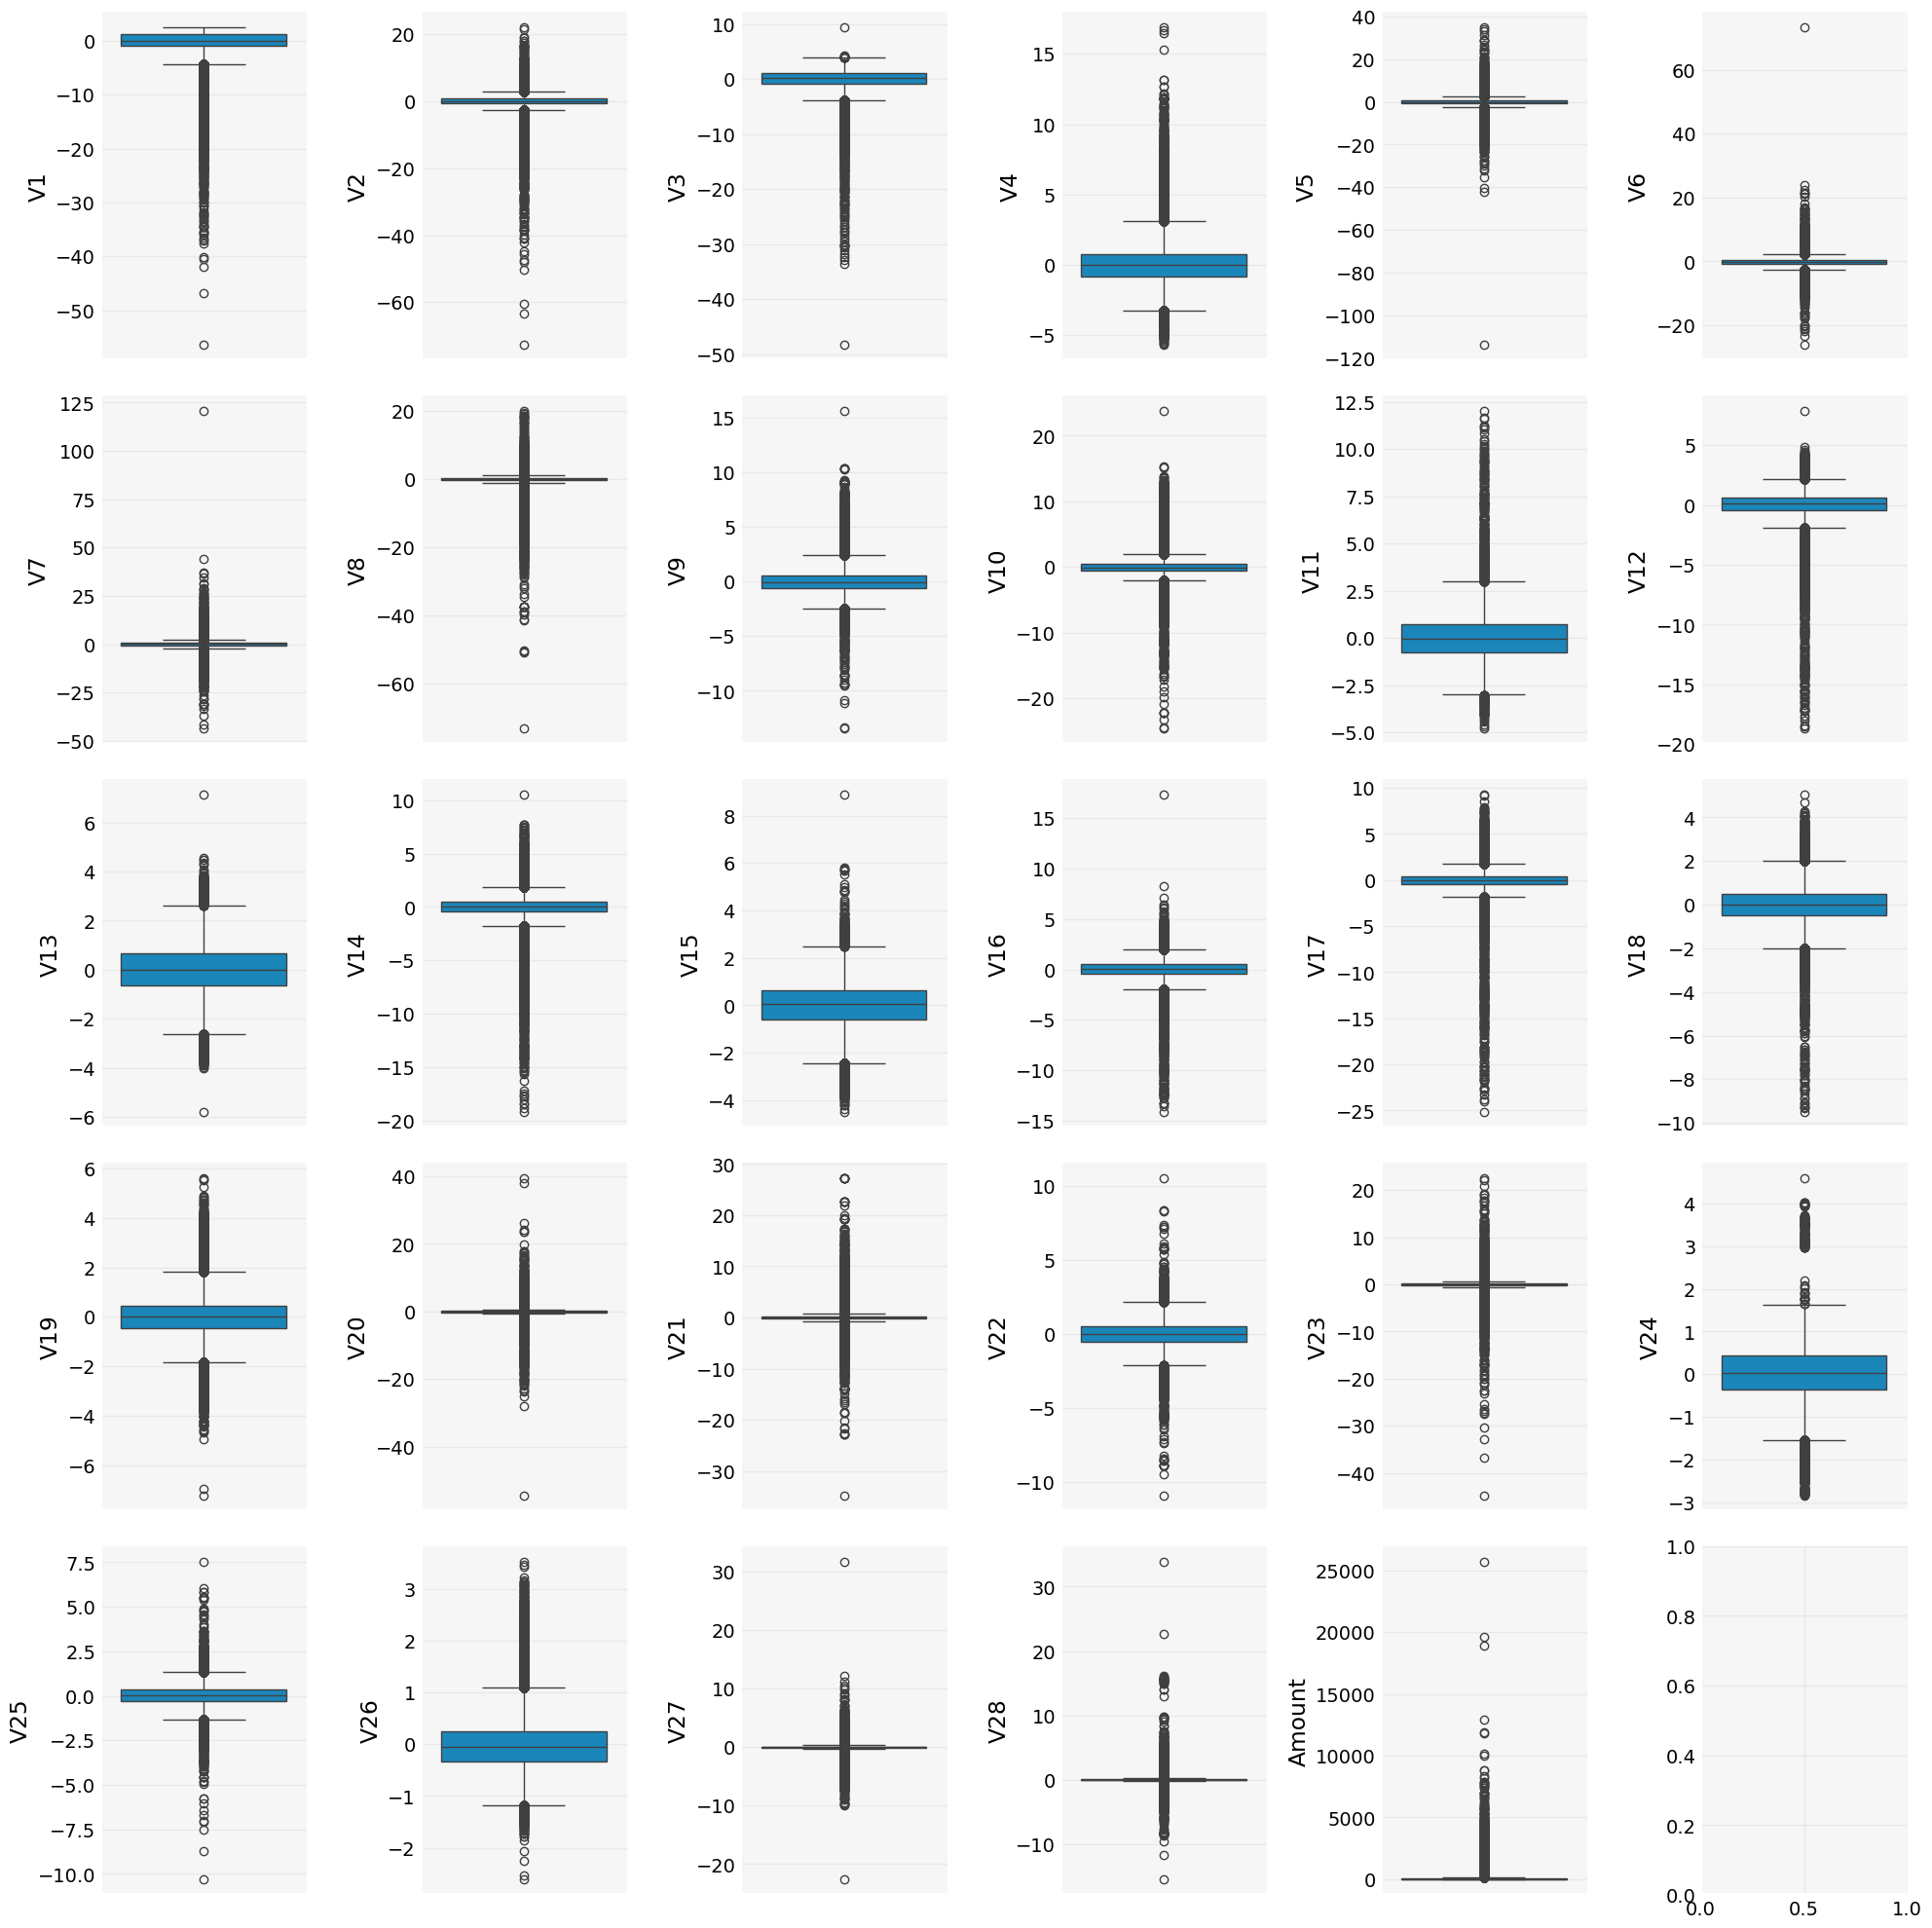

In [14]:
fig, axs = plt.subplots(*best_grid_shape(len(search_outliers_columns)), figsize=(20, 20))

for ax, col in zip(axs.ravel(), search_outliers_columns):
    sns.boxplot(data=df, y=col, ax=ax)

plt.tight_layout()
plt.show()

As can be seen, all the variables have outliers. But, since we are dealing with a classification problem, and with a huge class imbalance, we need to have a more careful approach to the outliers considering the target variable. We will analyze the outliers for each class separately:

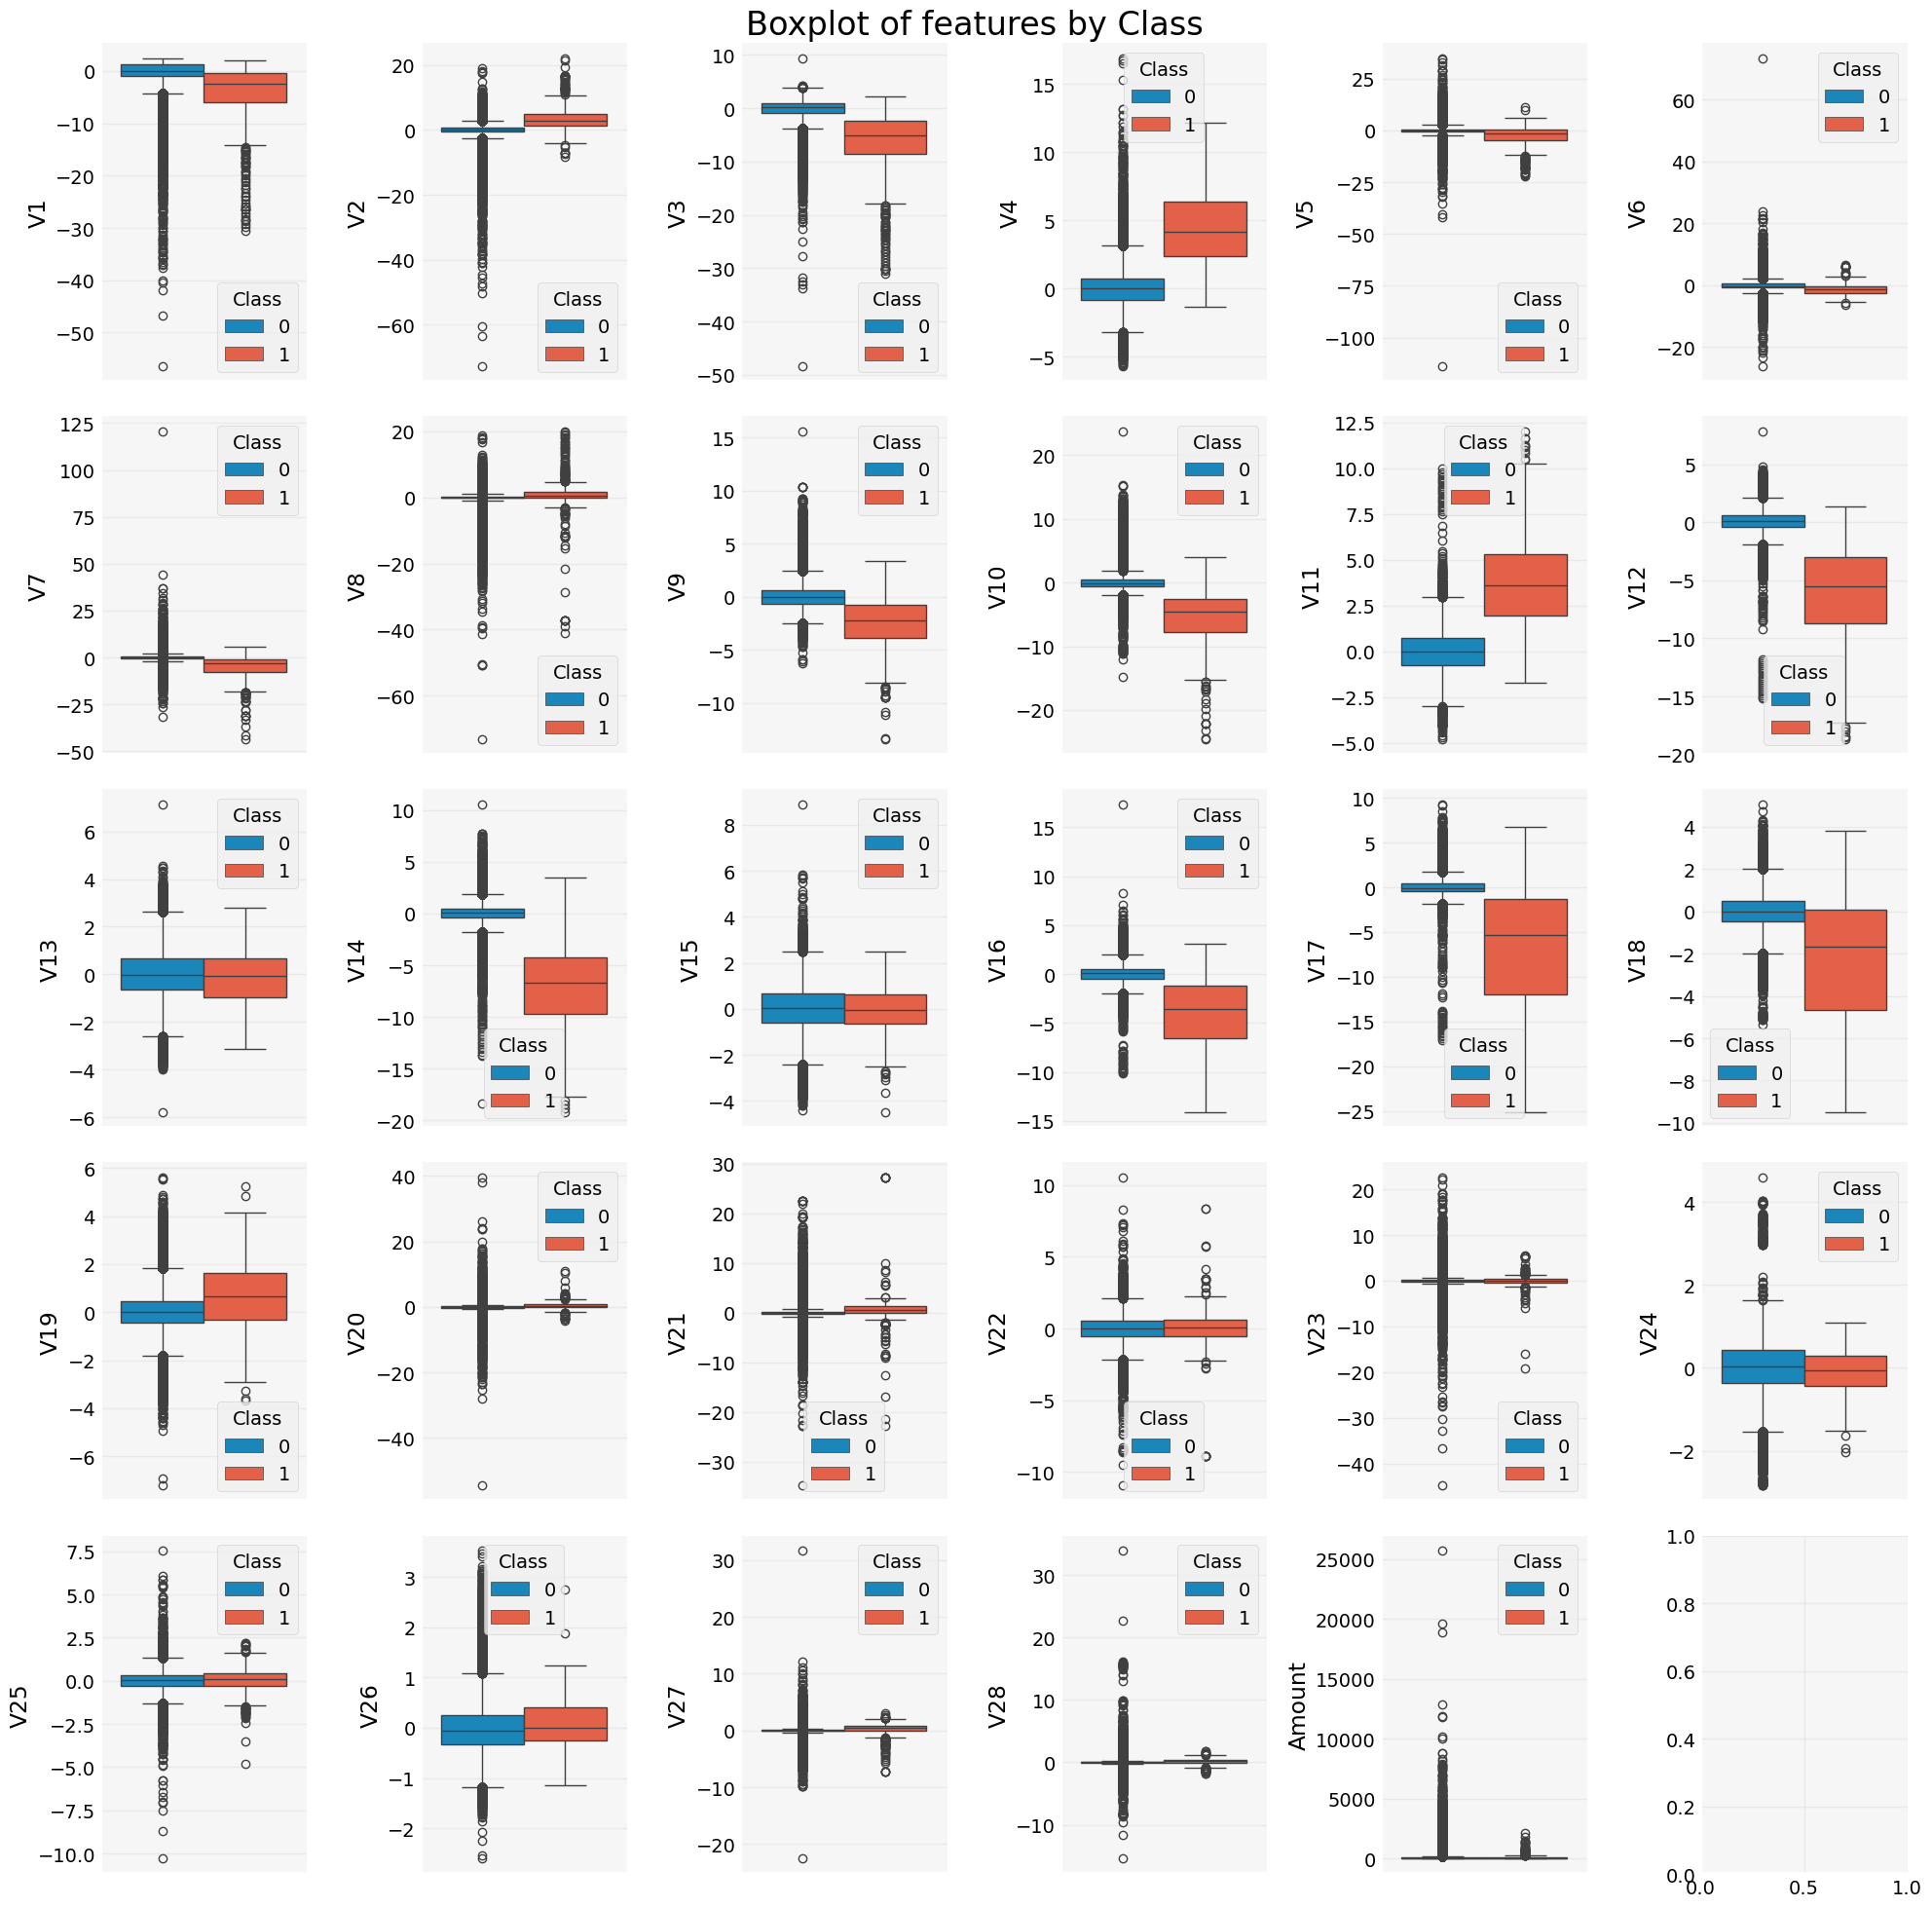

In [15]:
fig, axs = plt.subplots(
    *best_grid_shape(len(search_outliers_columns)), figsize=(20, 20), tight_layout=True
)

for ax, col in zip(axs.ravel(), search_outliers_columns):
    sns.boxplot(data=df, y=col, ax=ax, hue="Class")

fig.suptitle("Boxplot of features by Class")

plt.show()

- For legitimate transactions, the outliers are more spread out, with some variables having numerous outliers. This may be considered expected, as legitimate transactions are more numerous than frauds.
- For frauds, the outliers are more concentrated, with fewer variables having many outliers. This is also expected, as frauds are less numerous than legitimate transactions.
- The `Amount` variable has many outliers for both classes. This is expected, as the transaction value can vary greatly. But, as we can see, the outliers for legitimate transactions are more spread out, while the outliers for frauds are more concentrated.

Since the outliers are more concentrated for frauds, we will not remove them, as they may be important for the model to learn the patterns of fraud. We will only remove the outliers for legitimate transactions, as they may be noise in the data. This is not a standard approach, but since we are dealing with a classification problem and a huge class imbalance, we need to keep as much information as possible about the minority class.

Let's split the data into classes and remove the outliers for legitimate transactions considering quantiles.

In [16]:
df_class_0 = df[df["Class"] == 0]
df_class_1 = df[df["Class"] == 1]

df_class_0.shape, df_class_1.shape

((284315, 31), (492, 31))

In [17]:
lower_quantile_limit = 0.0025
upper_quantile_limit = 0.9975
df_class_0_no_outliers = remove_outliers_quantile(
    df_class_0, search_outliers_columns, lower_quantile_limit, upper_quantile_limit
)

df_no_outliers = pd.concat([df_class_0_no_outliers, df_class_1])

df_no_outliers.shape

(262594, 31)

We have used a conservative approach to remove the outliers, using a very low lower quantile and a very high upper quantile. This is because we want to remove only the most extreme outliers of the legitimate transactions, without distorting the data distribution too much.

In [18]:
df_no_outliers["Class"].value_counts(normalize=True).mul(100).round(3)

Class
0    99.813
1     0.187
Name: proportion, dtype: float64

See that the class imbalance is still present after removing the outliers.

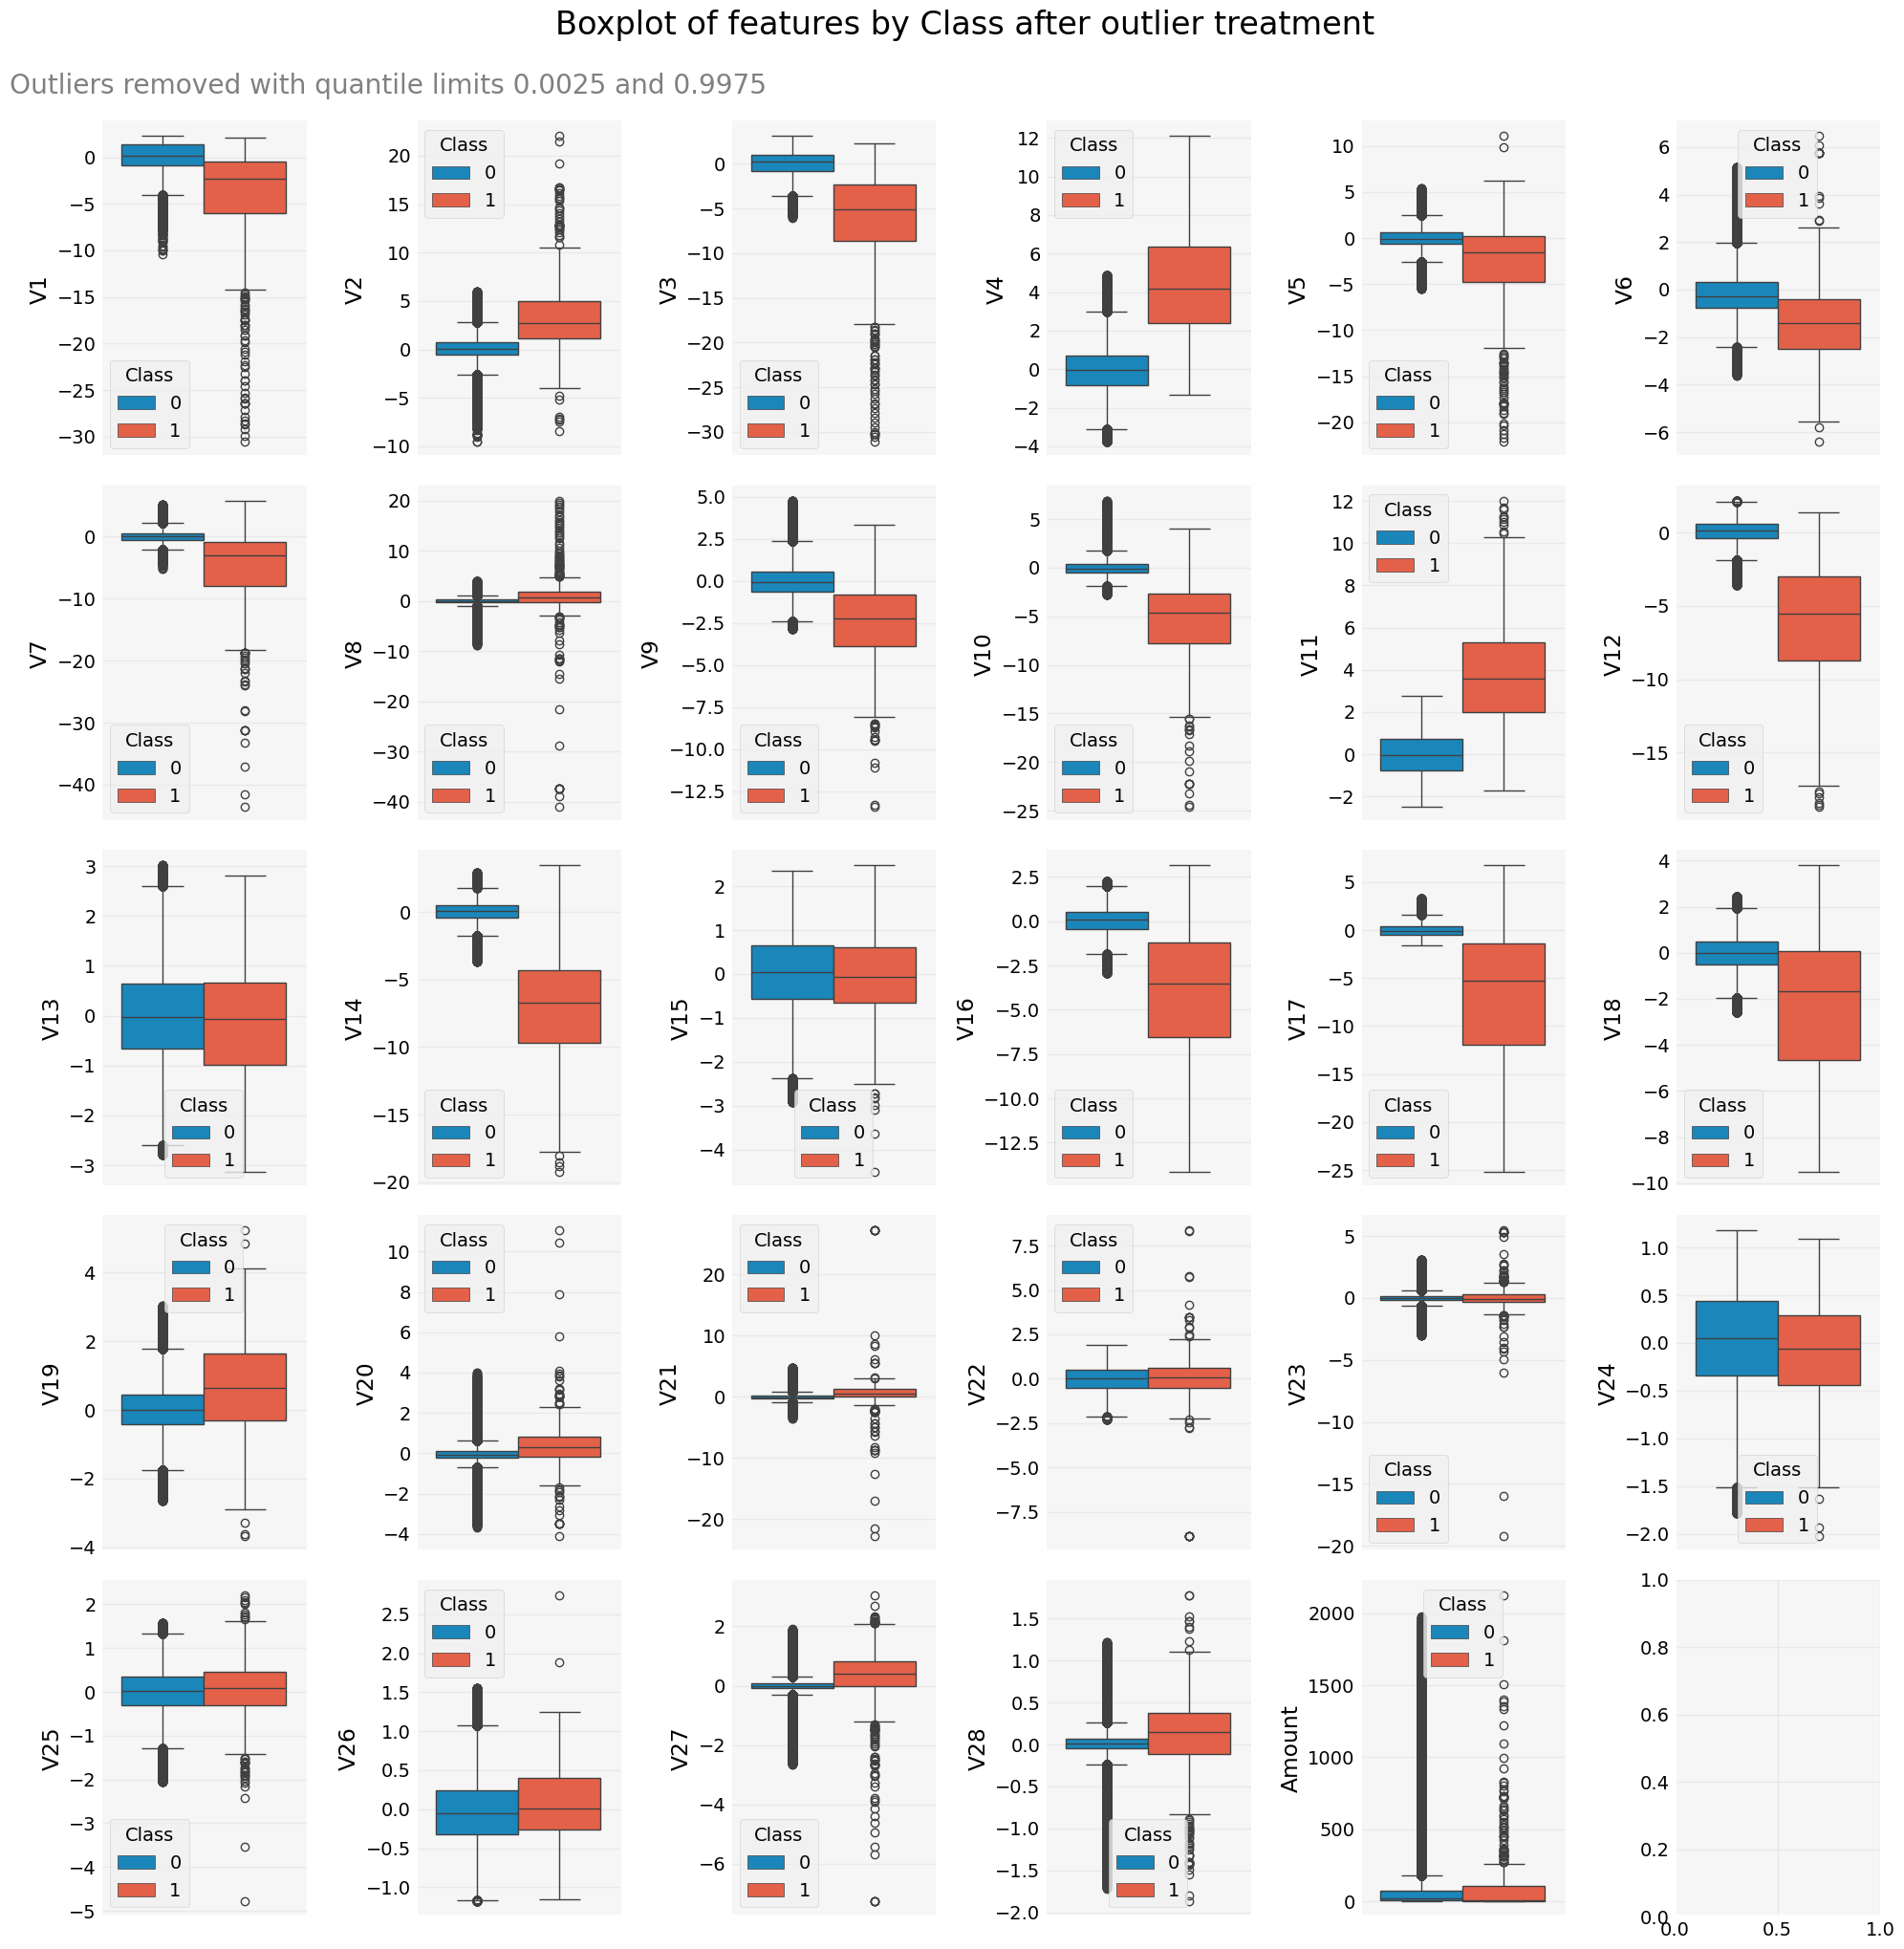

In [19]:
fig, axs = plt.subplots(
    *best_grid_shape(len(search_outliers_columns)), figsize=(20, 20), tight_layout=True
)

for ax, col in zip(axs.ravel(), search_outliers_columns):
    sns.boxplot(data=df_no_outliers, y=col, ax=ax, hue="Class")

fig.suptitle("Boxplot of features by Class after outlier treatment", y=1.02)

fig.text(
    0.0,
    0.98,
    f"Outliers removed with quantile limits {lower_quantile_limit} and {upper_quantile_limit}",
    ha="left",
    va="center",
    color="gray",
    fontsize="x-large"
)

plt.show()

Now, we see that the range of the variables are similar for both classes.

## Memory optimization and final dataset export

We can diminish the memory usage by converting the integer columns to an integer type with less memory usage:

In [20]:
# downcasting integer columns
for column in df_no_outliers.select_dtypes(include="integer").columns:
    df_no_outliers[column] = pd.to_numeric(df_no_outliers[column], downcast="integer")

df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262594 entries, 0 to 281674
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    262594 non-null  float64
 1   V1      262594 non-null  float64
 2   V2      262594 non-null  float64
 3   V3      262594 non-null  float64
 4   V4      262594 non-null  float64
 5   V5      262594 non-null  float64
 6   V6      262594 non-null  float64
 7   V7      262594 non-null  float64
 8   V8      262594 non-null  float64
 9   V9      262594 non-null  float64
 10  V10     262594 non-null  float64
 11  V11     262594 non-null  float64
 12  V12     262594 non-null  float64
 13  V13     262594 non-null  float64
 14  V14     262594 non-null  float64
 15  V15     262594 non-null  float64
 16  V16     262594 non-null  float64
 17  V17     262594 non-null  float64
 18  V18     262594 non-null  float64
 19  V19     262594 non-null  float64
 20  V20     262594 non-null  float64
 21  V21     262594 

The parquet format is a columnar storage format that is efficient for reading and writing data. It is a good choice for storing datasets keeping the data types and the metadata. We can export the final dataset to a parquet file:

In [21]:
df_no_outliers.to_parquet(INTERIM_DATA_FILE, index=False, engine="fastparquet")